# Fianl Project

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit,train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.tree import plot_tree
from datetime import datetime

In [2]:
#导入数据集
data1 = pd.read_csv("crsp.csv")
data1.head()

,Unnamed: 0,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME
0,1,10000,NaN,NaN,NaN,198512,NaN,NaN
1,2,10000,10.0,OMFGA,3.0,198601,NaN,16100.0
2,3,10000,10.0,OMFGA,3.0,198602,-0.257143,11960.0
3,4,10000,10.0,OMFGA,3.0,198603,0.365385,16330.0
4,5,10000,10.0,OMFGA,3.0,198604,-0.098592,15172.0


In [3]:
#导入数据集
data2 = pd.read_csv("signed_predictors_dl_wide.csv")
data2.head()

,permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
0,10000,198601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.785175e-08,NaN
2,10000,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.023392e-07,NaN
3,10000,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.467463e-08,NaN
4,10000,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.649551e-08,NaN


In [4]:
#合并数据集
merged_data = pd.merge(data1, data2, left_on=['PERMNO', 'yearMon'], right_on=['permno', 'yyyymm'], how = 'inner')
merged_data.head()

,Unnamed: 0,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME,permno,yyyymm,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
0,2,10000,10.0,OMFGA,3.0,198601,NaN,16100.000000,10000,198601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,10000,10.0,OMFGA,3.0,198602,-0.257143,11960.000000,10000,198602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.785175e-08,NaN
2,4,10000,10.0,OMFGA,3.0,198603,0.365385,16330.000000,10000,198603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.023392e-07,NaN
3,5,10000,10.0,OMFGA,3.0,198604,-0.098592,15172.000000,10000,198604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.467463e-08,NaN
4,6,10000,10.0,OMFGA,3.0,198605,-0.222656,11793.859375,10000,198605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.649551e-08,NaN


In [5]:
# 删除重复的permno、yyyymm两列变量
columns_to_drop = ['permno', 'yyyymm']
merged_data = merged_data.drop(columns=columns_to_drop)
# 删除未命名的第一列序号
merged_data = merged_data.iloc[:,1:]
merged_data.head()

,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME,AM,AOP,AbnormalAccruals,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
0,10000,10.0,OMFGA,3.0,198601,NaN,16100.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,10.0,OMFGA,3.0,198602,-0.257143,11960.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.785175e-08,NaN
2,10000,10.0,OMFGA,3.0,198603,0.365385,16330.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.023392e-07,NaN
3,10000,10.0,OMFGA,3.0,198604,-0.098592,15172.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.467463e-08,NaN
4,10000,10.0,OMFGA,3.0,198605,-0.222656,11793.859375,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.649551e-08,NaN


In [6]:
# 按照时间（yearMon）升序排序
merged_data = merged_data.sort_values(by='yearMon')
merged_data = merged_data[merged_data['yearMon'] >= 197001]
merged_data.head()

,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME,AM,AOP,AbnormalAccruals,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade,zerotradeAlt1,zerotradeAlt12
589926,16707,11.0,JM,1.0,197001,-0.070833,460801.625,1.036889,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.844669,1.376087e-07,1.134581e-07,1.631493e-07
1396575,40256,10.0,IPH,2.0,197001,-0.166667,10300.000,3.194175,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.052373,NaN,3.060816e-08,3.025547e-08,3.389152e-08
387122,13573,10.0,NP,1.0,197001,-0.012500,221508.125,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.750563e-07,1.189248e-07,2.277207e-07
920209,25347,10.0,FPC,1.0,197001,-0.009009,37991.250,4.085151,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.055224,0.662227,5.057194e-08,4.062929e-08,3.720154e-08
1631919,47570,10.0,ATI,1.0,197001,0.204545,54232.250,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.849711e-07,1.036356e-07,2.879576e-07


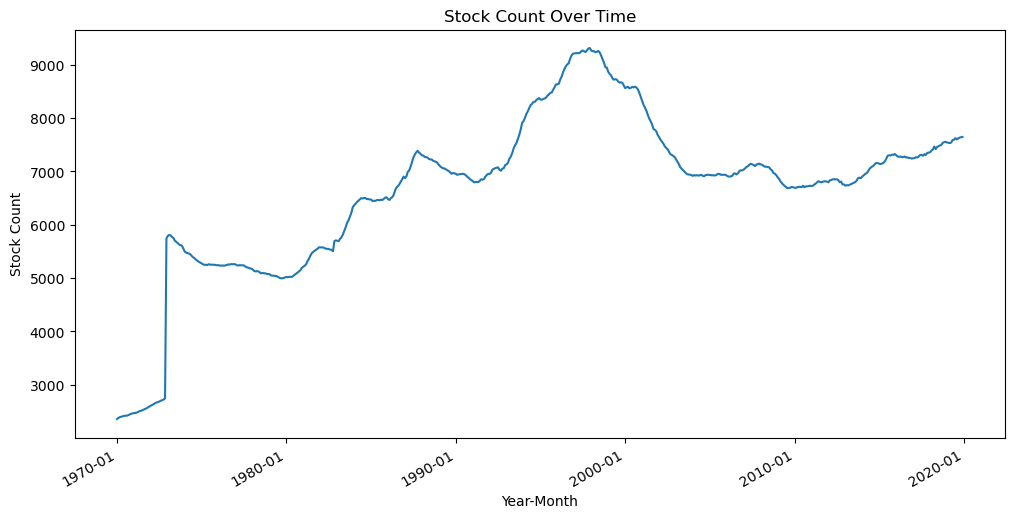

In [177]:
# 将 "yearMon" 列转换为日期类型
merged_data['yearMon'] = pd.to_datetime(merged_data['yearMon'], format='%Y%m')

# 统计不同时间点的股票数量
stock_count_by_time = merged_data.groupby('yearMon')['PERMNO'].nunique().reset_index()

# 使用 Matplotlib 创建折线图
plt.figure(figsize=(12, 6))
plt.plot(stock_count_by_time['yearMon'], stock_count_by_time['PERMNO'],linestyle='-')

# 设置图表标题和标签
plt.title('Stock Count Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Stock Count')

# 格式化 x 轴上的日期标签
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# 自动调整日期标签，以避免重叠
plt.gcf().autofmt_xdate()

# 显示图表
plt.show()

In [8]:
sample = merged_data.copy()

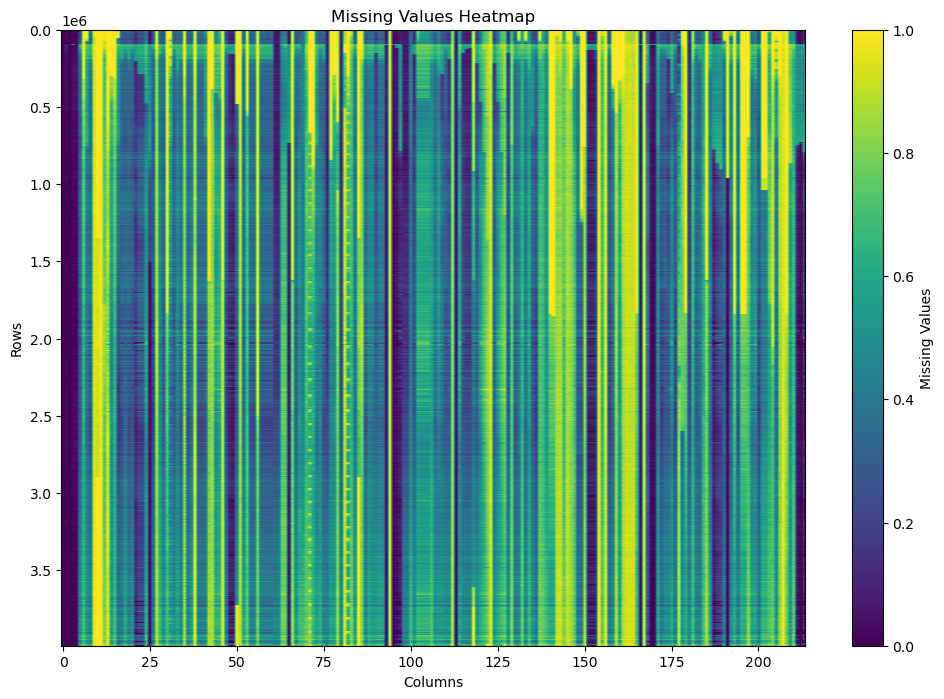

In [9]:
# 计算每列的缺失值比例
missing_values_percentage = sample.isnull().mean() * 100

# 选择一定比例以上的缺失值列（可以根据实际需求调整阈值）
threshold = 0  # 选择有缺失值的列
selected_columns = missing_values_percentage[missing_values_percentage > threshold].index

# 创建缺失值热力图
plt.figure(figsize=(12, 8))
plt.imshow(sample[selected_columns].isnull(), cmap='viridis', aspect='auto')

# 设置图表标题和标签
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')

# 显示颜色条
plt.colorbar(label='Missing Values')

# 显示图表
plt.show()

In [13]:
# 根据缺失值比例删除变量
missing_threshold = 25  # 设定阈值
variables_to_drop = missing_values_percentage[missing_values_percentage > missing_threshold].index
# 查看要删除变量及个数
print(variables_to_drop)

Index(['AM', 'AOP', 'AbnormalAccruals', 'Accruals', 'AccrualsBM', 'Activism1',
       'Activism2', 'AdExp', 'AgeIPO', 'AnalystRevision',
       ...
       'iomom_cust', 'iomom_supp', 'realestate', 'retConglomerate', 'roaq',
       'sfe', 'sinAlgo', 'skew1', 'std_turn', 'tang'],
      dtype='object', length=180)


In [14]:
# 删除变量
clean_sample = sample.drop(columns=variables_to_drop)

In [15]:
clean_sample.head()

,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME,Beta,BidAskSpread,CoskewACX,...,PriceDelaySlope,PriceDelayTstat,RealizedVol,ReturnSkew,ReturnSkew3F,Spinoff,VolMkt,zerotrade,zerotradeAlt1,zerotradeAlt12
589926,16707,11.0,JM,1.0,1970-01-01,-0.070833,460801.625,0.742297,0.009127,-0.017924,...,0.516184,1.117325,-0.019990,-0.373212,-0.396960,0.0,-0.020581,1.376087e-07,1.134581e-07,1.631493e-07
1396575,40256,10.0,IPH,2.0,1970-01-01,-0.166667,10300.000,1.930220,0.009044,-0.126149,...,1.134521,1.938260,-0.020958,-0.079717,-0.299226,0.0,-0.146039,3.060816e-08,3.025547e-08,3.389152e-08
387122,13573,10.0,NP,1.0,1970-01-01,-0.012500,221508.125,0.641481,0.004532,-0.172197,...,NaN,NaN,-0.013077,-0.356643,0.501317,0.0,-0.013178,2.750563e-07,1.189248e-07,2.277207e-07
920209,25347,10.0,FPC,1.0,1970-01-01,-0.009009,37991.250,1.419327,0.006467,0.061467,...,0.287249,0.592557,-0.024534,0.073448,0.152535,0.0,-0.133681,5.057194e-08,4.062929e-08,3.720154e-08
1631919,47570,10.0,ATI,1.0,1970-01-01,0.204545,54232.250,NaN,0.010329,-0.058006,...,-3.796654,NaN,-0.060997,-2.367667,0.057057,0.0,-0.018668,1.849711e-07,1.036356e-07,2.879576e-07


In [16]:
# 处理其余缺失值，使用众数填充
final_sample = clean_sample.apply(lambda col: col.fillna(col.mode()[0]))

In [17]:
final_sample.head()

,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME,Beta,BidAskSpread,CoskewACX,...,PriceDelaySlope,PriceDelayTstat,RealizedVol,ReturnSkew,ReturnSkew3F,Spinoff,VolMkt,zerotrade,zerotradeAlt1,zerotradeAlt12
589926,16707,11.0,JM,1.0,1970-01-01,-0.070833,460801.625,0.742297,0.009127,-0.017924,...,0.516184,1.117325,-0.019990,-0.373212,-0.396960,0.0,-0.020581,1.376087e-07,1.134581e-07,1.631493e-07
1396575,40256,10.0,IPH,2.0,1970-01-01,-0.166667,10300.000,1.930220,0.009044,-0.126149,...,1.134521,1.938260,-0.020958,-0.079717,-0.299226,0.0,-0.146039,3.060816e-08,3.025547e-08,3.389152e-08
387122,13573,10.0,NP,1.0,1970-01-01,-0.012500,221508.125,0.641481,0.004532,-0.172197,...,1.556650,2.068513,-0.013077,-0.356643,0.501317,0.0,-0.013178,2.750563e-07,1.189248e-07,2.277207e-07
920209,25347,10.0,FPC,1.0,1970-01-01,-0.009009,37991.250,1.419327,0.006467,0.061467,...,0.287249,0.592557,-0.024534,0.073448,0.152535,0.0,-0.133681,5.057194e-08,4.062929e-08,3.720154e-08
1631919,47570,10.0,ATI,1.0,1970-01-01,0.204545,54232.250,-17.866266,0.010329,-0.058006,...,-3.796654,2.068513,-0.060997,-2.367667,0.057057,0.0,-0.018668,1.849711e-07,1.036356e-07,2.879576e-07


In [18]:
# 检查处理后缺失值情况
df = pd.DataFrame(final_sample)
print(df.isnull().any())
print(df.columns[df.isnull().any()])

PERMNO             False
SHRCD              False
TICKER             False
EXCHCD             False
yearMon            False
RET                False
ME                 False
Beta               False
BidAskSpread       False
CoskewACX          False
Coskewness         False
DivInit            False
DivOmit            False
DolVol             False
ExchSwitch         False
FirmAge            False
High52             False
IdioVol3F          False
IdioVolAHT         False
Illiquidity        False
IndIPO             False
IndMom             False
MaxRet             False
Mom12mOffSeason    False
Mom6m              False
PriceDelayRsq      False
PriceDelaySlope    False
PriceDelayTstat    False
RealizedVol        False
ReturnSkew         False
ReturnSkew3F       False
Spinoff            False
VolMkt             False
zerotrade          False
zerotradeAlt1      False
zerotradeAlt12     False
dtype: bool
Index([], dtype='object')


In [19]:
# 获取所有列名
# shrcd：表明股票的交易类型
# exchcd：股票交易所在交易所代码
# permno：CRSP证券唯一标识，是公司股票永久编码
all_columns = final_sample.columns
# 'RET' 是因变量列名
dependent_variable = 'RET'
# 获取自变量列名（排除'PERMNO','SHRCD','TICKER','EXCHCD','yearMon' 和 'RET' 列）
independent_variables = [col for col in all_columns if col not in ['PERMNO','SHRCD','TICKER','EXCHCD','yearMon', dependent_variable]]

In [20]:
# 将数据按照 'yearMon' 进行分组
grouped_data = final_sample.groupby('yearMon')

# 标准化每个时点的横截面数据
scaler = StandardScaler()

# 初始化一个空的 DataFrame 用于存储标准化后的数据
normalized_data = pd.DataFrame()

for time_point, group in grouped_data:
    # 获取自变量和因变量的列
    all_columns = independent_variables + [dependent_variable]
    
    # 标准化自变量和因变量
    group[all_columns] = scaler.fit_transform(group[all_columns])
    
    # 将标准化后的数据追加到新的 DataFrame
    normalized_data = pd.concat([normalized_data, group])

# 重置索引，因为 concat 后索引可能重复
normalized_data = normalized_data.reset_index(drop=True)
normalized_data.head()

,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME,Beta,BidAskSpread,CoskewACX,...,PriceDelaySlope,PriceDelayTstat,RealizedVol,ReturnSkew,ReturnSkew3F,Spinoff,VolMkt,zerotrade,zerotradeAlt1,zerotradeAlt12
0,16707,11.0,JM,1.0,1970-01-01,-0.286961,0.172138,0.383453,-0.117964,-0.142841,...,-0.020940,-0.006683,0.476272,-0.117946,-0.440150,-0.192196,0.389235,-0.383715,-0.30042,-0.337451
1,40256,10.0,IPH,2.0,1970-01-01,-1.124781,-0.200994,0.558491,-0.119603,-1.162353,...,-0.020834,0.703015,0.407151,0.155472,-0.304187,-0.192196,-1.901426,-0.383715,-0.30042,-0.337451
2,13573,10.0,NP,1.0,1970-01-01,0.223017,-0.026059,0.368598,-0.208281,-1.596146,...,-0.020762,0.815619,0.969613,-0.102510,0.809494,-0.192196,0.524405,-0.383715,-0.30042,-0.337451
3,25347,10.0,FPC,1.0,1970-01-01,0.253537,-0.178059,0.483212,-0.170244,0.605051,...,-0.020979,-0.460345,0.151962,0.298160,0.324283,-0.192196,-1.675789,-0.383715,-0.30042,-0.337451
4,47570,10.0,ATI,1.0,1970-01-01,2.120531,-0.164607,-2.358480,-0.094347,-0.520424,...,-0.021680,0.815619,-2.450345,-1.975964,0.191459,-0.192196,0.424177,-0.383715,-0.30042,-0.337451


In [21]:
# 获取处理数据
data = normalized_data.sort_values(by='yearMon').copy()
data.head()

,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME,Beta,BidAskSpread,CoskewACX,...,PriceDelaySlope,PriceDelayTstat,RealizedVol,ReturnSkew,ReturnSkew3F,Spinoff,VolMkt,zerotrade,zerotradeAlt1,zerotradeAlt12
0,16707,11.0,JM,1.0,1970-01-01,-0.286961,0.172138,0.383453,-0.117964,-0.142841,...,-0.020940,-0.006683,0.476272,-0.117946,-0.440150,-0.192196,0.389235,-0.383715,-0.30042,-0.337451
1568,35166,10.0,PBD,2.0,1970-01-01,1.308615,-0.182906,0.459055,-0.122759,-0.423196,...,-0.020901,-0.020625,0.105077,-0.066534,-0.127021,-0.192196,-1.012641,-0.383715,-0.30042,-0.337451
1569,28257,10.0,SWL,1.0,1970-01-01,-0.281209,-0.084175,0.396124,-0.172091,0.932683,...,-0.020762,0.815619,0.686817,0.393926,-0.049987,-0.192196,0.272736,-0.383715,-0.30042,-0.337451
1570,32854,10.0,HG,2.0,1970-01-01,-1.722557,-0.122312,0.408284,-0.070405,-0.010196,...,-0.020709,0.005715,-0.047934,-0.160363,-0.056585,-0.192196,-4.653726,-0.383715,-0.30042,-0.337451
1571,49680,48.0,DMG,1.0,1970-01-01,-0.473467,-0.094154,-2.358480,-0.168192,1.248373,...,-0.020762,0.815619,0.718947,0.672855,0.598641,-0.192196,0.765021,-0.285473,-0.30042,-0.278034


In [22]:
# 将每家公司的特征滞后一期
for var in independent_variables:
    data[f'{var}_lag'] = data.groupby('PERMNO')[var].transform(lambda x: x.shift(1))
data.head()

,PERMNO,SHRCD,TICKER,EXCHCD,yearMon,RET,ME,Beta,BidAskSpread,CoskewACX,...,PriceDelaySlope_lag,PriceDelayTstat_lag,RealizedVol_lag,ReturnSkew_lag,ReturnSkew3F_lag,Spinoff_lag,VolMkt_lag,zerotrade_lag,zerotradeAlt1_lag,zerotradeAlt12_lag
0,16707,11.0,JM,1.0,1970-01-01,-0.286961,0.172138,0.383453,-0.117964,-0.142841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568,35166,10.0,PBD,2.0,1970-01-01,1.308615,-0.182906,0.459055,-0.122759,-0.423196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1569,28257,10.0,SWL,1.0,1970-01-01,-0.281209,-0.084175,0.396124,-0.172091,0.932683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1570,32854,10.0,HG,2.0,1970-01-01,-1.722557,-0.122312,0.408284,-0.070405,-0.010196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1571,49680,48.0,DMG,1.0,1970-01-01,-0.473467,-0.094154,-2.358480,-0.168192,1.248373,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# 删除因为滞后一期出现的缺失值
final_data = data.dropna()

In [126]:
# 定义特征变量与目标变量
features = final_data[[f'{var}_lag' for var in independent_variables]]
target = final_data[dependent_variable]
group = final_data['yearMon']
full_data = final_data[['PERMNO']+['yearMon']+[dependent_variable]+[f'{var}_lag' for var in independent_variables]]

In [25]:
features.head()

,ME_lag,Beta_lag,BidAskSpread_lag,CoskewACX_lag,Coskewness_lag,DivInit_lag,DivOmit_lag,DolVol_lag,ExchSwitch_lag,FirmAge_lag,...,PriceDelaySlope_lag,PriceDelayTstat_lag,RealizedVol_lag,ReturnSkew_lag,ReturnSkew3F_lag,Spinoff_lag,VolMkt_lag,zerotrade_lag,zerotradeAlt1_lag,zerotradeAlt12_lag
3944,2.536672,0.386717,-0.168842,0.037250,1.420929,-0.151636,0.113519,-2.721547,0.109623,0.058902,...,-0.021825,1.351387,0.242818,0.532448,0.558320,-0.192196,0.097263,-0.383715,-0.30042,-0.337451
3940,-0.139895,-2.358480,0.041313,1.248373,-0.875938,-0.151636,0.113519,-1.590497,0.109623,0.876944,...,-0.020762,0.815619,-2.197351,-0.907729,-1.191228,5.203021,0.765021,-0.383715,-0.30042,-0.278034
3941,-0.186095,0.555034,-0.121601,-0.654717,-2.282739,-0.151636,0.113519,1.152013,0.109623,0.753355,...,-0.020875,0.016154,-0.536338,0.177597,0.215557,-0.192196,0.437477,-0.294016,-0.30042,-0.283200
3942,-0.209525,-2.358480,-0.244699,-0.044697,0.593351,-0.151636,0.113519,-1.047181,-9.122186,0.388473,...,-0.020876,0.757441,-0.095742,1.720836,-0.423596,-0.192196,0.765021,-0.383715,-0.30042,-0.337451
3943,-0.196514,-2.358480,-0.077564,1.248373,-0.875938,-0.151636,0.113519,1.759100,0.109623,0.912255,...,-0.020762,0.815619,-1.090123,-0.268963,0.024045,-0.192196,0.765021,-0.285473,-0.30042,-0.278034


In [26]:
target.head()

3944   -0.663717
3940   -0.235919
3941    1.663960
3942   -0.888921
3943    2.892068
Name: RET, dtype: float64

In [28]:
full_data.head()

,yearMon,RET,ME_lag,Beta_lag,BidAskSpread_lag,CoskewACX_lag,Coskewness_lag,DivInit_lag,DivOmit_lag,DolVol_lag,...,PriceDelaySlope_lag,PriceDelayTstat_lag,RealizedVol_lag,ReturnSkew_lag,ReturnSkew3F_lag,Spinoff_lag,VolMkt_lag,zerotrade_lag,zerotradeAlt1_lag,zerotradeAlt12_lag
3944,1970-02-01,-0.663717,2.536672,0.386717,-0.168842,0.037250,1.420929,-0.151636,0.113519,-2.721547,...,-0.021825,1.351387,0.242818,0.532448,0.558320,-0.192196,0.097263,-0.383715,-0.30042,-0.337451
3940,1970-02-01,-0.235919,-0.139895,-2.358480,0.041313,1.248373,-0.875938,-0.151636,0.113519,-1.590497,...,-0.020762,0.815619,-2.197351,-0.907729,-1.191228,5.203021,0.765021,-0.383715,-0.30042,-0.278034
3941,1970-02-01,1.663960,-0.186095,0.555034,-0.121601,-0.654717,-2.282739,-0.151636,0.113519,1.152013,...,-0.020875,0.016154,-0.536338,0.177597,0.215557,-0.192196,0.437477,-0.294016,-0.30042,-0.283200
3942,1970-02-01,-0.888921,-0.209525,-2.358480,-0.244699,-0.044697,0.593351,-0.151636,0.113519,-1.047181,...,-0.020876,0.757441,-0.095742,1.720836,-0.423596,-0.192196,0.765021,-0.383715,-0.30042,-0.337451
3943,1970-02-01,2.892068,-0.196514,-2.358480,-0.077564,1.248373,-0.875938,-0.151636,0.113519,1.759100,...,-0.020762,0.815619,-1.090123,-0.268963,0.024045,-0.192196,0.765021,-0.285473,-0.30042,-0.278034


In [30]:
# 划分数据为训练集（包括训练集和验证集）和测试集
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.01,shuffle=False)

In [31]:
n_samples = len(features_train)
print(n_samples)

3917565


In [87]:
# 初始化时间序列交叉验证
tscv = TimeSeriesSplit(max_train_size=356142,n_splits=10)

In [97]:
# 创建线性回归模型
model = LinearRegression()

In [98]:
for train_index, val_index in tscv.split(features_train,target_train):
    print("%s %s" % (train_index, val_index))

[     3      4      5 ... 356142 356143 356144] [356145 356146 356147 ... 712284 712285 712286]
[356145 356146 356147 ... 712284 712285 712286] [ 712287  712288  712289 ... 1068426 1068427 1068428]
[ 712287  712288  712289 ... 1068426 1068427 1068428] [1068429 1068430 1068431 ... 1424568 1424569 1424570]
[1068429 1068430 1068431 ... 1424568 1424569 1424570] [1424571 1424572 1424573 ... 1780710 1780711 1780712]
[1424571 1424572 1424573 ... 1780710 1780711 1780712] [1780713 1780714 1780715 ... 2136852 2136853 2136854]
[1780713 1780714 1780715 ... 2136852 2136853 2136854] [2136855 2136856 2136857 ... 2492994 2492995 2492996]
[2136855 2136856 2136857 ... 2492994 2492995 2492996] [2492997 2492998 2492999 ... 2849136 2849137 2849138]
[2492997 2492998 2492999 ... 2849136 2849137 2849138] [2849139 2849140 2849141 ... 3205278 3205279 3205280]
[2849139 2849140 2849141 ... 3205278 3205279 3205280] [3205281 3205282 3205283 ... 3561420 3561421 3561422]
[3205281 3205282 3205283 ... 3561420 3561421 3

In [99]:
for train_index, val_index in tscv.split(features_train,target_train):
    features_train_fold = features_train.iloc[train_index]
    target_train_fold = target_train.iloc[train_index]
    model.fit(features_train_fold, target_train_fold)


target_pred = model.predict(features_test)
# 计算模型在测试集上的表现
mse_ols = mean_squared_error(target_test, target_pred)
r2_ols = r2_score(target_test, target_pred)
# 获取回归系数
b_ols = model.coef_
print(f'Model: {model.__class__.__name__}')
print(f'MSE: {mse_ols}')
print(f'R2: {r2_ols}')
print(f'b: {b_ols}')
print('--------------------------')

Model: LinearRegression
MSE: 1.0029560557651969
R2: 0.0008465270356252663
b: [ 5.55535718e-04  1.09830338e-02 -7.37860939e-03  1.65671911e-02
 -2.34912642e-03  2.46662198e-03 -2.27250874e-04  1.95624865e-02
  4.12805592e-06 -1.00351659e-02  3.51554403e-02  3.88341966e-02
 -5.98939179e-03  1.42913631e-02 -7.68741793e-03  2.39952613e-02
 -5.64216254e-03 -6.32053431e-03  3.57246690e-03  5.00131887e-04
  2.62348834e-04  3.44743435e-03  5.59409722e-03 -2.12551308e-03
  2.38141923e-03  3.07486930e-03  3.49395527e-03  1.37159313e-03
 -3.13047782e-03 -1.49538205e-03]
--------------------------


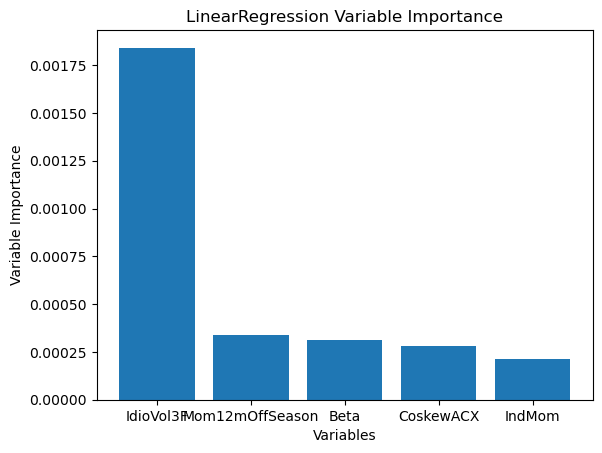

In [115]:
variable_importance = []
for j in range(features_test.shape[1]):
    features_test_j = features_test.copy()
    features_test_j.iloc[:, j] = 0  # 将第 j 个变量全部替换为 0
    target_pred_j = model.predict(features_test_j)

    r2_j = r2_score(target_test, target_pred_j)
    variable_importance.append((r2 - r2_j, j))
variable_importance.sort(reverse=True)
# 提取前五名的变量名和重要性值
top_variables = [independent_variables[j] for _, j in variable_importance[:5]]
top_importances = [vi for vi, _ in variable_importance[:5]]
# 画出各模型的前五名变量重要性,绘制柱状图
plt.bar(top_variables, top_importances)
plt.title(f"{model.__class__.__name__} Variable Importance")
plt.xlabel("Variables")
plt.ylabel("Variable Importance")
plt.show()

In [111]:
model1 = Lasso()
params = {'alpha': [0.01,0.05,0.1,1,10,100]}

In [112]:
grid = GridSearchCV(model1, params, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
model_lasso = grid.best_estimator_
target_pred = model_lasso.predict(features_test)
# 计算模型在测试集上的表现
mse_lasso = mean_squared_error(target_test, target_pred)
r2_lasso = r2_score(target_test, target_pred)
# 获取回归系数
b_lasso = model_lasso.coef_
print('Model: Lasso')
print(f'Best parameters: {grid.best_params_}')
print(f'MSE: {mse_lasso}')
print(f'R2: {r2_lasso}')
print(f'b: {b_lasso}')
print('--------------------------')

Model: Lasso
Best parameters: {'alpha': 0.01}
MSE: 1.0018983395153453
R2: 0.0019002330862294414
b: [ 0.          0.00387965 -0.          0.          0.00123555  0.
  0.          0.          0.         -0.          0.00889695  0.
  0.          0.00361834  0.          0.00311099  0.01679554  0.
  0.         -0.          0.          0.          0.         -0.
 -0.          0.          0.00217967  0.          0.          0.00221147]
--------------------------


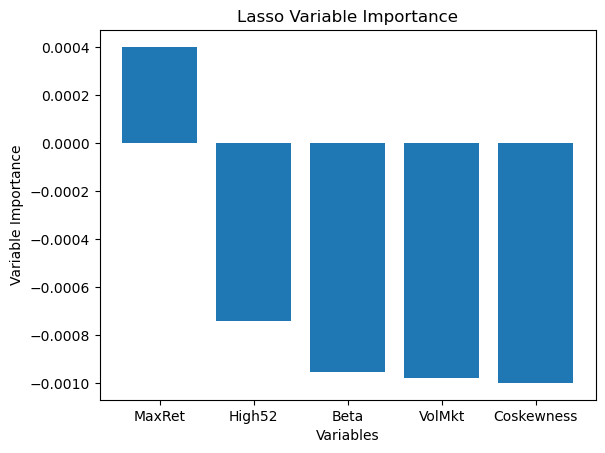

In [117]:
variable_importance = []
for j in range(features_test.shape[1]):
    features_test_j = features_test.copy()
    features_test_j.iloc[:, j] = 0  # 将第 j 个变量全部替换为 0
    target_pred_j = model_lasso.predict(features_test_j)
    r2_j = r2_score(target_test, target_pred_j)
    variable_importance.append((r2 - r2_j, j))
variable_importance.sort(reverse=True)
# 提取前五名的变量名和重要性值
top_variables = [independent_variables[j] for _, j in variable_importance[:5]]
top_importances = [vi for vi, _ in variable_importance[:5]]
# 画出各模型的前五名变量重要性,绘制柱状图
plt.bar(top_variables, top_importances)
plt.title(f"{model_lasso.__class__.__name__} Variable Importance")
plt.xlabel("Variables")
plt.ylabel("Variable Importance")
plt.show()

In [93]:
model2 = Ridge()
params = {'alpha': [0.01,0.05,0.1,1,100]}

In [94]:
grid = GridSearchCV(model2, params, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
model_ridge = grid.best_estimator_
target_pred = model_ridge.predict(features_test)
# 计算模型在测试集上的表现
mse_ridge = mean_squared_error(target_test, target_pred)
r2_ridge = r2_score(target_test, target_pred)
# 获取回归系数
b_ridge = model_ridge.coef_
print('Model: Ridge')
print(f'Best parameters: {grid.best_params_}')
print(f'MSE: {mse_ridge}')
print(f'R2: {r2_ridge}')
print(f'b: {b_ridge}')
print('--------------------------')

Model: Ridge
Best parameters: {'alpha': 100}
MSE: 1.0015452258960773
R2: 0.002252007919249066
b: [ 0.00135495  0.01476997  0.00405994  0.00394624  0.00828392  0.00469324
  0.00142117  0.01818228  0.00217598 -0.00612922  0.01414928 -0.00027705
  0.01216762  0.01484026  0.00111266  0.01234604  0.04667748  0.00531515
  0.00053654 -0.00371576  0.00053992  0.00127451 -0.02010289 -0.01026216
 -0.00151497  0.00812169  0.00542764  0.00197249 -0.00028934  0.00149141]
--------------------------


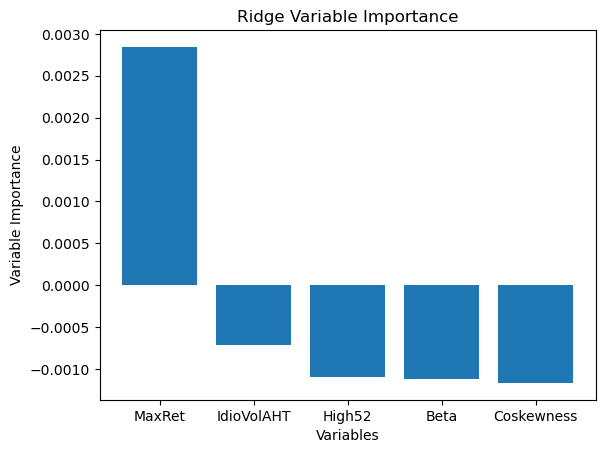

In [118]:
variable_importance = []
for j in range(features_test.shape[1]):
    features_test_j = features_test.copy()
    features_test_j.iloc[:, j] = 0  # 将第 j 个变量全部替换为 0
    target_pred_j = model_ridge.predict(features_test_j)
    r2_j = r2_score(target_test, target_pred_j)
    variable_importance.append((r2 - r2_j, j))
variable_importance.sort(reverse=True)
# 提取前五名的变量名和重要性值
top_variables = [independent_variables[j] for _, j in variable_importance[:5]]
top_importances = [vi for vi, _ in variable_importance[:5]]
# 画出各模型的前五名变量重要性,绘制柱状图
plt.bar(top_variables, top_importances)
plt.title(f"{model_ridge.__class__.__name__} Variable Importance")
plt.xlabel("Variables")
plt.ylabel("Variable Importance")
plt.show()

In [50]:
model3 = DecisionTreeRegressor()
params = {'max_depth': [3, 5, 7, 9, None], 'min_samples_split': [2, 4, 6, 8]} # Decision tree

In [51]:
grid = GridSearchCV(model3, params, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
model_tree = grid.best_estimator_
target_pred = model_tree.predict(features_test)
# 计算模型在测试集上的表现
mse_tree = mean_squared_error(target_test, target_pred)
r2_tree = r2_score(target_test, target_pred)
print('Model: DecisionTreeRegressor')
print(f'Best parameters: {grid.best_params_}')
print(f'MSE: {mse_tree}')
print(f'R2: {r2_tree}')
print('--------------------------')

Model: DecisionTreeRegressor
Best parameters: {'max_depth': 3, 'min_samples_split': 4}
MSE: 1.002603522360182
R2: 0.0011977238542015822
--------------------------


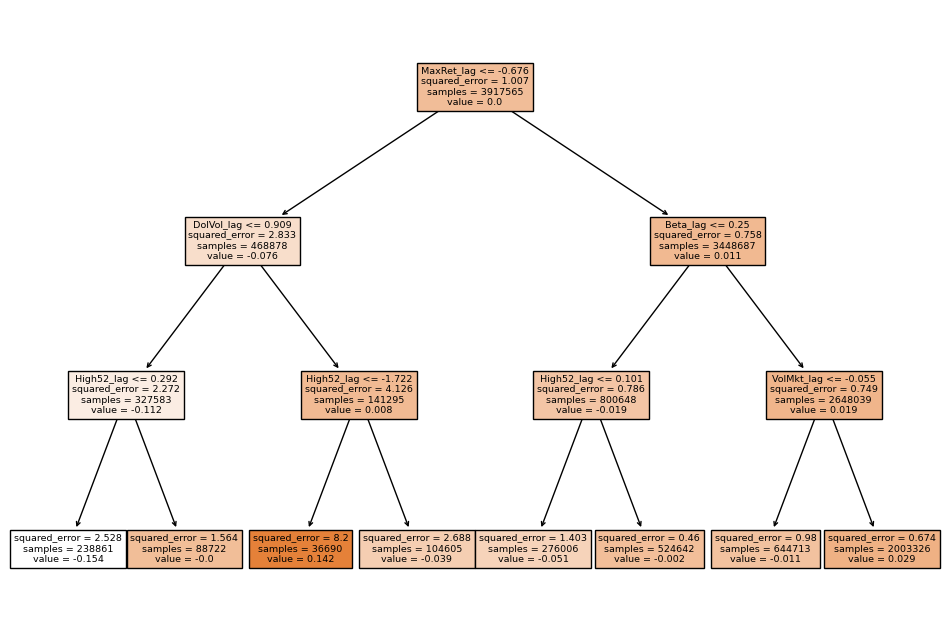

In [52]:
# 画出最优超参数下的估计树
plt.figure(figsize=(12, 8))
plot_tree(model_tree, filled=True, feature_names=list(features_train.columns))
plt.show()

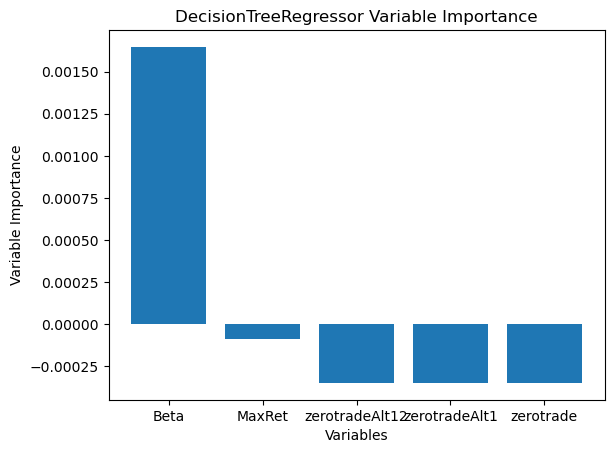

In [119]:
variable_importance = []
for j in range(features_test.shape[1]):
    features_test_j = features_test.copy()
    features_test_j.iloc[:, j] = 0  # 将第 j 个变量全部替换为 0
    target_pred_j = model_tree.predict(features_test_j)
    r2_j = r2_score(target_test, target_pred_j)
    variable_importance.append((r2 - r2_j, j))
variable_importance.sort(reverse=True)
# 提取前五名的变量名和重要性值
top_variables = [independent_variables[j] for _, j in variable_importance[:5]]
top_importances = [vi for vi, _ in variable_importance[:5]]
# 画出各模型的前五名变量重要性,绘制柱状图
plt.bar(top_variables, top_importances)
plt.title(f"{model_tree.__class__.__name__} Variable Importance")
plt.xlabel("Variables")
plt.ylabel("Variable Importance")
plt.show()

In [198]:
model4 = RandomForestRegressor(n_estimators=100,n_jobs=-1)
params = {'max_depth':[5,10,15],'min_samples_split':[100,200,300]}

In [199]:
grid = GridSearchCV(model4, params, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
model_rf = grid.best_estimator_
target_pred = model_rf.predict(features_test)
# 计算模型在测试集上的表现
mse_rf = mean_squared_error(target_test[dependent_variable], target_pred)
r2_rf = r2_score(target_test[dependent_variable], target_pred)
print('Model: RandomForestRegressor')
print(f'Best parameters: {grid.best_params_}')
print(f'MSE: {mse_rf}')
print(f'R2: {r2_rf}')
print('--------------------------')

KeyboardInterrupt: 

In [ ]:
variable_importance = []
for j in range(features_test.shape[1]):
    features_test_j = features_test.copy()
    features_test_j.iloc[:, j] = 0  # 将第 j 个变量全部替换为 0
    target_pred_j = model_rf.predict(features_test_j)
    r2_j = r2_score(target_test, target_pred_j)
    variable_importance.append((r2 - r2_j, j))
variable_importance.sort(reverse=True)
# 提取前五名的变量名和重要性值
top_variables = [independent_variables[j] for _, j in variable_importance[:5]]
top_importances = [vi for vi, _ in variable_importance[:5]]
# 画出各模型的前五名变量重要性,绘制柱状图
plt.bar(top_variables, top_importances)
plt.title(f"{model_rf.__class__.__name__} Variable Importance")
plt.xlabel("Variables")
plt.ylabel("Variable Importance")
plt.show()

In [53]:
# 将数据转化为张量（Tensor）
X_train = torch.from_numpy(features_train.to_numpy()).float()
y_train = torch.from_numpy(target_train.to_numpy()).float().view(-1, 1)

In [54]:
# 将数据转化为张量（Tensor）
X_test = torch.from_numpy(features_test.to_numpy()).float()
y_test = torch.from_numpy(target_test.to_numpy()).float().view(-1, 1)

In [55]:
# 定义神经网络模型
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [200]:
# 使用小批量进行梯度更新，即每一轮350个样本计算预测误差并更新梯度，最多进行100轮
epochs = 100
batch_size = 350
# 创建数据加载器
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [202]:
# 初始化模型、损失函数和优化器
model_nn = SimpleNN(input_size=features_train.shape[1], hidden_size1=32, hidden_size2=16, output_size=1)
criterion = nn.MSELoss() # 使用均方误差
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)  # 使用Adam优化器优化模型的参数

In [203]:
# Patience：当Validation loss连续10轮上升后，停止训练以避免过拟合
patience = 10
best_loss = float('inf')

In [ ]:
for train_index, val_index in tscv.split(features_train,target_train):
    features_train_fold = features_train.iloc[train_index]
    target_train_fold = target_train.iloc[train_index]
    features_val_fold = features_train.iloc[val_index]
    target_val_fold = target_train.iloc[val_index]
    X_train = torch.from_numpy(features_train_fold.to_numpy()).float()
    y_train = torch.from_numpy(target_train_fold.to_numpy()).float().view(-1, 1)
    X_val = torch.from_numpy(features_val_fold.to_numpy()).float()
    y_val = torch.from_numpy(target_val_fold.to_numpy()).float().view(-1, 1)
    # 创建数据加载器
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    
        # 训练模型
    for epoch in range(epochs):
        # 将模型设置为训练模式
        model_nn.train()
        # 加载小批量数据
        for X_batch, y_batch in train_loader:
            y_pred = model_nn(X_batch) # 前向传播，进行预测
            loss = criterion(y_pred, y_batch) # 计算预测损失，loss是一个Tensor，可对之前所有参数求导
            loss.backward() # 反向传播梯度
            optimizer.step() # 更新模型参数
            optimizer.zero_grad() # 更新结束，梯度归零
        # 每10轮打印一次训练集损失
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
        # 在验证集上计算Valid Loss
        model_nn.eval() # 将模型调至评估模式
        val_loss = 0 # 初始化验证集损失
        # 使用 torch.no_grad 避免跟踪梯度（此时不需要）
        with torch.no_grad():
            for X_batch, y_batch in val_loader: # 对批量循环
                y_pred = model_nn(X_batch) # 进行预测
                val_loss += criterion(y_pred, y_batch) # 计算损失并累加
            val_loss /= len(val_loader) # 计算平均误差
        # 每10轮打印一次验证集损失
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Validation Loss: {val_loss.item():.4f}')
        # 比较当前验证集损失与最佳损失，决定是否需要结束训练
        if val_loss < best_loss:
            best_loss = val_loss
            patience = 10
        else:
            patience -= 1
        if patience == 0:
            print(f'Early stopping at epoch {epoch}')
            break

Epoch 0, Loss: 0.8405
Epoch 0, Validation Loss: 1.0029
Epoch 10, Loss: 0.8461
Epoch 10, Validation Loss: 1.0020
Early stopping at epoch 19
Epoch 0, Loss: 0.8055
Epoch 0, Validation Loss: 1.0088
Epoch 10, Loss: 0.7991
Epoch 10, Validation Loss: 1.0105
Epoch 20, Loss: 0.8013
Epoch 20, Validation Loss: 1.0138
Epoch 30, Loss: 0.8063
Epoch 30, Validation Loss: 1.0162
Epoch 40, Loss: 0.8082
Epoch 40, Validation Loss: 1.0180
Epoch 50, Loss: 0.8004
Epoch 50, Validation Loss: 1.0200
Epoch 60, Loss: 0.7934
Epoch 60, Validation Loss: 1.0226
Epoch 70, Loss: 0.7924
Epoch 70, Validation Loss: 1.0238
Epoch 80, Loss: 0.7868
Epoch 80, Validation Loss: 1.0259
Epoch 90, Loss: 0.7787
Epoch 90, Validation Loss: 1.0297
Epoch 0, Loss: 0.8218
Epoch 0, Validation Loss: 1.0050
Epoch 10, Loss: 0.7944
Epoch 10, Validation Loss: 1.0049
Epoch 20, Loss: 0.7809
Epoch 20, Validation Loss: 1.0079
Epoch 30, Loss: 0.7809
Epoch 30, Validation Loss: 1.0124
Epoch 40, Loss: 0.7761
Epoch 40, Validation Loss: 1.0113
Epoch 50, 

In [83]:
# 计算测试集上的表现
model_nn.eval()
# 初始化预测结果和真实标签
y_preds = []
y_targets = []
# 对批量循环，加载整个测试集，并进行预测
for X_batch, y_batch in test_loader:
    y_pred = model_nn(X_batch)
    # 将Tensor格式的数据转回普通的Numpy向量
    y_pred = y_pred.detach().numpy()
    y_batch = y_batch.detach().numpy()
    # 延长列表
    y_preds.extend(y_pred)
    y_targets.extend(y_batch)
# 计算并打印测试集上的表现
mse_nn = mean_squared_error(y_targets, y_preds)
r2_nn = r2_score(y_targets, y_preds)
print(f'MSE: {mse_nn}')
print(f'R2: {r2_nn}')

MSE: 1.033003330230713
R2: -0.02908680312920331


In [ ]:
variable_importance = []
for j in range(features_test.shape[1]):
    features_test_j = features_test.copy()
    features_test_j.iloc[:, j] = 0  # 将第 j 个变量全部替换为 0
    target_pred_j = model_rf.predict(features_test_j)
    r2_j = r2_score(target_test, target_pred_j)
    variable_importance.append((r2 - r2_j, j))
variable_importance.sort(reverse=True)
# 提取前五名的变量名和重要性值
top_variables = [independent_variables[j] for _, j in variable_importance[:5]]
top_importances = [vi for vi, _ in variable_importance[:5]]
# 画出各模型的前五名变量重要性,绘制柱状图
plt.bar(top_variables, top_importances)
plt.title(f"{model_rf.__class__.__name__} Variable Importance")
plt.xlabel("Variables")
plt.ylabel("Variable Importance")
plt.show()

In [121]:
ols_predictions = model.predict(features)
lasso_predictions = model_lasso.predict(features)
ridge_predictions = model_ridge.predict(features)
tree_predictions = model_tree.predict(features)
#rf_predictions = model_rf.predict(features)
#nn_predictions = model_nn.predict(features)

In [122]:
# 将预测结果放入一个数组中
# all_predictions = np.array([ols_predictions,lasso_predictions,ridge_predictions,tree_predictions,rf_predictions,nn_predictions])
all_predictions = np.array([ols_predictions,lasso_predictions,ridge_predictions,tree_predictions])
# 使用平均法进行集成ensemble_predictions 就是最终的集成预测结果
ensemble_predictions = np.mean(all_predictions, axis=0)

In [128]:
# 在得到预测结果后，你可以按照预测的收益率从高到低对公司进行排序
sorted_companies = pd.DataFrame({'yearMon': full_data['yearMon'],'PERMNO': full_data['PERMNO'], 'Predicted_Return': ensemble_predictions, 'Actual_Return': full_data['RET'], 'ME_lag': full_data['ME_lag']}).sort_values(by='Predicted_Return', ascending=False)

In [129]:
sorted_companies.head()

,yearMon,PERMNO,Predicted_Return,Actual_Return,ME_lag
2055942,1998-01-01,78906,1.227112,-0.473211,-0.150345
3725180,2017-01-01,63079,1.156538,0.248589,-0.182959
1348269,1990-08-01,11792,1.135744,3.502086,-0.196319
2941176,2007-08-01,87349,0.842463,-1.339295,-0.107323
3136105,2009-12-01,82668,0.831733,-2.271287,-0.195455


In [180]:
print(sorted_companies)

           yearMon  PERMNO  Predicted_Return  Actual_Return    ME_lag
2055942 1998-01-01   78906          1.227112      -0.473211 -0.150345
3725180 2017-01-01   63079          1.156538       0.248589 -0.182959
1348269 1990-08-01   11792          1.135744       3.502086 -0.196319
2941176 2007-08-01   87349          0.842463      -1.339295 -0.107323
3136105 2009-12-01   82668          0.831733      -2.271287 -0.195455
...            ...     ...               ...            ...       ...
2563465 2003-02-01   81288         -1.239936       1.181886 -0.169667
3949419 2019-07-01   92345         -1.258232      -1.750483 -0.184166
2152801 1998-12-01   86050         -1.260009      -2.113198 -0.149231
2045555 1997-12-01   82490         -1.366564      -4.292195 -0.179278
2474527 2002-02-01   86070         -1.396576      -1.464327 -0.155721

[3957137 rows x 5 columns]


In [184]:
# 假设 df 是包含 yearMon 变量的 DataFrame
sorted_companies['yearMon'] = pd.to_datetime(sorted_companies['yearMon'])  # 将字符串转换为 datetime 对象

# 设置截止日期
cutoff_date = datetime(2010, 1, 1)

# 筛选数据
sorted_companies = sorted_companies[sorted_companies['yearMon'] >= cutoff_date]

In [185]:
print(sorted_companies)

           yearMon  PERMNO  Predicted_Return  Actual_Return    ME_lag
3725180 2017-01-01   63079          1.156538       0.248589 -0.182959
3913258 2019-02-01   16400          0.745828      -7.116053  0.128166
3164009 2010-04-01   79129          0.744402      -0.514088  0.209206
3744732 2017-04-01   13113          0.737224       1.157065 -0.205635
3605040 2015-09-01   13751          0.673772       3.981252 -0.215115
...            ...     ...               ...            ...       ...
3702823 2016-10-01   14101         -1.177044       0.945651 -0.175301
3426481 2013-07-01   12964         -1.193279      -0.392049 -0.225602
3851334 2018-06-01   16894         -1.196551       0.874305 -0.194984
3490788 2014-05-01   62958         -1.222675       1.042693 -0.226066
3949419 2019-07-01   92345         -1.258232      -1.750483 -0.184166

[846484 rows x 5 columns]


In [186]:
# 定义函数计算市值加权平均收益
def weighted_average_return(group):
    weights = group['ME_lag']
    returns = group['Actual_Return']
    return np.average(returns, weights=weights)

In [187]:
# 按 'yearMon' 分组
grouped_data = sorted_companies.groupby('yearMon')

In [188]:
# 初始化一个空的 DataFrame 用于存储结果
result_df = pd.DataFrame()

In [189]:
# 对每个 'yearMon' 组执行以下步骤
for name, group in grouped_data:
    # 按 'ensemble_predictions' 从高到低排序
    group = group.sort_values(by='Predicted_Return', ascending=False)
    
    # 将排序后的公司分成 10 组
    group['quantile'] = pd.qcut(group['Predicted_Return'], q=10, labels=False)
    
    # 计算每一组的市值加权平均收益
    group_result = group.groupby('quantile').apply(weighted_average_return)
    group_result = group_result.sort_values(ascending=True)
    
    # 将 'yearMon' 和结果添加到总的 DataFrame 中
    result_df = pd.concat([result_df, pd.DataFrame({'yearMon': [name] * len(group_result), 'weighted_avg_return': group_result.values})])
    # 按照 'yearMon' 分组并对每组中的 'weighted_avg_return' 进行降序排序
    result_df = result_df.groupby('yearMon').apply(lambda x: x.sort_values(by='weighted_avg_return', ascending=False)).reset_index(drop=True)
# 打印结果
print(result_df)

        yearMon  weighted_avg_return
0    2010-01-01             2.693947
1    2010-01-01             1.281071
2    2010-01-01             0.378042
3    2010-01-01             0.284911
4    2010-01-01             0.252073
...         ...                  ...
1195 2019-12-01            -0.013957
1196 2019-12-01            -0.185012
1197 2019-12-01            -0.190692
1198 2019-12-01            -0.228560
1199 2019-12-01            -0.959804

[1200 rows x 2 columns]


In [190]:
import math
# 初始化投资金额
initial_investment = 100
portfolio={}
for time,group in result_df.groupby('yearMon'):
    # 获取每个月的第一行和最后一行
    first_row = group.iloc[0]
    last_row = group.iloc[-1]

    # 计算每个月的做多和做空组收益率
    long_return = first_row['weighted_avg_return']
    short_return = last_row['weighted_avg_return']
    portfolio_return = initial_investment * (1 + long_return) * (1 - short_return)
    # 计算累积收益的对数
    log_portfolio_return = np.log(portfolio_return)
    # 将结果存储到数据框中
    portfolio.update({time:log_portfolio_return})

In [191]:
print(portfolio)

{Timestamp('2010-01-01 00:00:00'): 6.3689628097966136, Timestamp('2010-02-01 00:00:00'): 7.484424477513002, Timestamp('2010-03-01 00:00:00'): 5.073880594327623, Timestamp('2010-04-01 00:00:00'): 6.45530984234846, Timestamp('2010-05-01 00:00:00'): 8.065544014191103, Timestamp('2010-06-01 00:00:00'): 7.397538792599292, Timestamp('2010-07-01 00:00:00'): 6.339118214558217, Timestamp('2010-08-01 00:00:00'): 6.100614682500095, Timestamp('2010-09-01 00:00:00'): 9.598425641600832, Timestamp('2010-10-01 00:00:00'): 6.056695470167388, Timestamp('2010-11-01 00:00:00'): 6.209563765142477, Timestamp('2010-12-01 00:00:00'): 6.892962805287611, Timestamp('2011-01-01 00:00:00'): 5.782573155112948, Timestamp('2011-02-01 00:00:00'): 5.377032332194597, Timestamp('2011-03-01 00:00:00'): 8.246836760339685, Timestamp('2011-04-01 00:00:00'): 5.462927093947929, Timestamp('2011-05-01 00:00:00'): 5.964178829317782, Timestamp('2011-06-01 00:00:00'): 5.887680493775842, Timestamp('2011-07-01 00:00:00'): 7.112569144

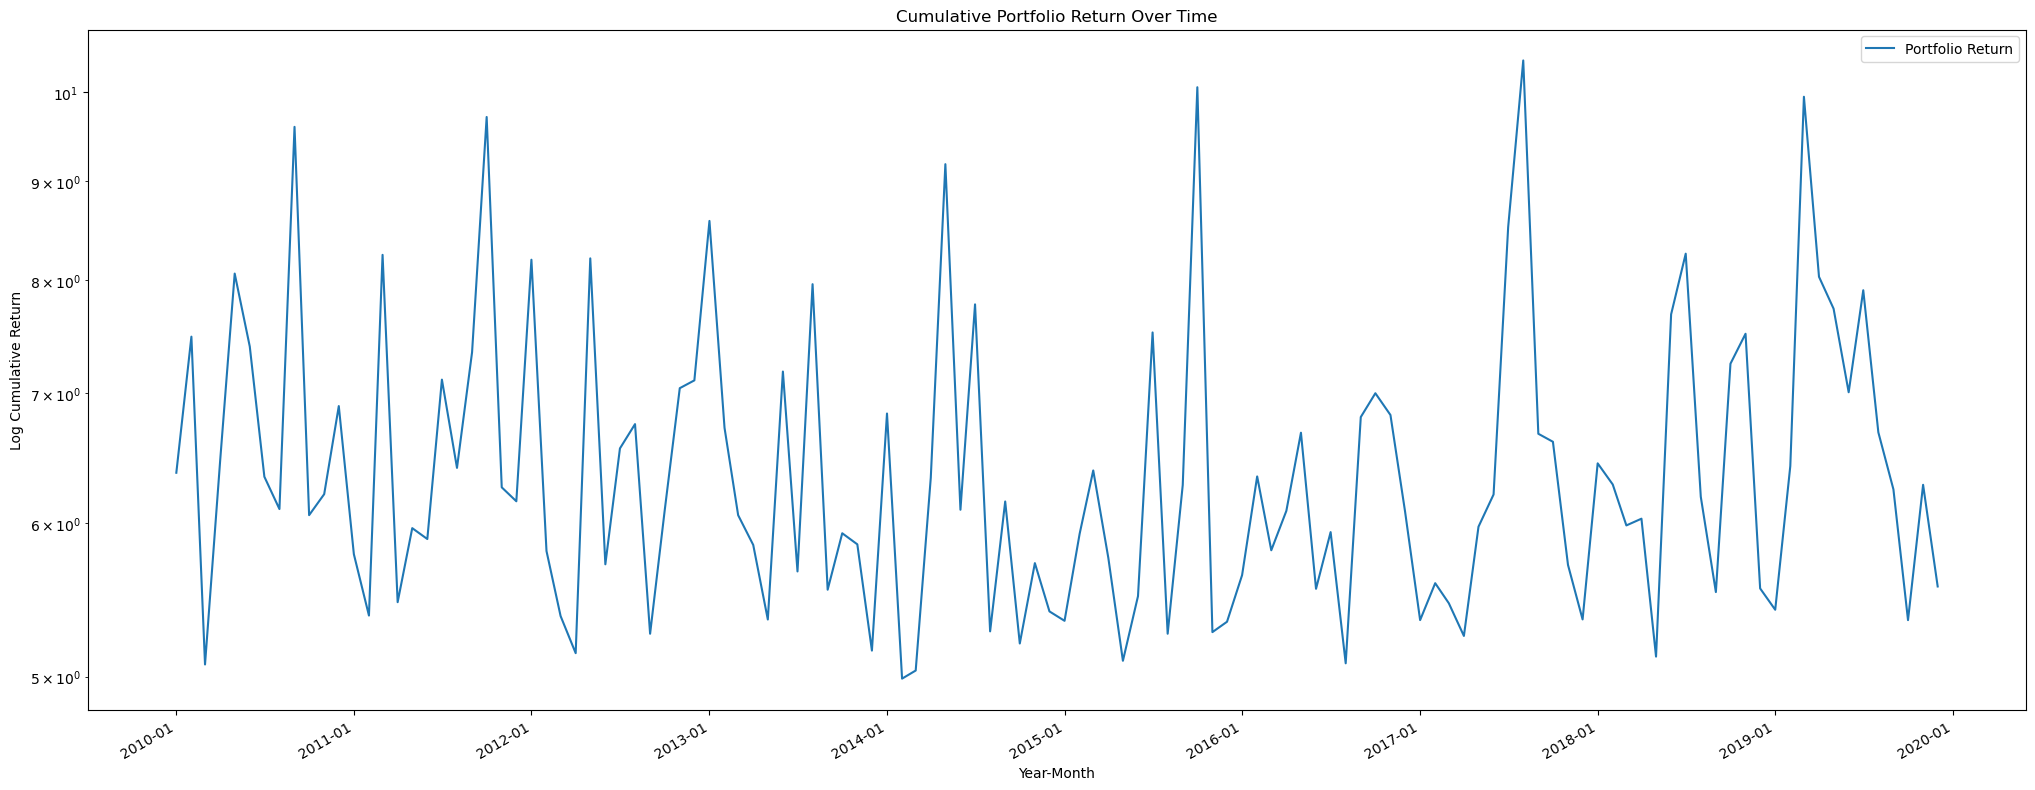

In [194]:
plt.figure(figsize=(25, 10))
plt.plot(portfolio.keys(), portfolio.values(), label='Portfolio Return', linestyle='-')
plt.title('Cumulative Portfolio Return Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Log Cumulative Return')
plt.legend()
plt.yscale('log')  # 使用对数坐标
# 格式化 x 轴上的日期标签
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# 自动调整日期标签，以避免重叠
plt.gcf().autofmt_xdate()

# 显示图表
plt.show()